In [2]:
import time
import random
import requests
import collections
import scrapy
import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from time import sleep
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
import seaborn as sns
import sklearn as skl


# Ключевые моменты

1. Скреппинг данных с сайта DNS
2. Обработка этих данных с использованием регулярных выражений
3. Графики и ML
4. Динамика цен на телефоны за 2 дня
5. Получение данных у СДЭК о посылках через недокоментированный API
6. Небольшой анализ с помощью библиотеки networknx
7. Визуализация посылок на реальной карте, использьуя folium

## Скреппинг DNS

In [4]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager


br = webdriver.Chrome(ChromeDriverManager().install())
ref = 'https://www.dns-shop.ru/catalog/17a8a01d16404e77/smartfony/'
br.get(ref)

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [C:\Users\vesel\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache


In [5]:
# Использую Selenium, чтобы получить данные

smartphones = []
prices = []
links = []

nxt = br.find_element(By.CSS_SELECTOR, ".pagination-widget__page-link_next")

for i in range(42):
    smrt = br.find_elements(By.CSS_SELECTOR, ".ui-link_black span") # smartphones
    for i in smrt:
        smartphones.append(i.text)
    
    prcs = br.find_elements(By.CSS_SELECTOR, ".product-buy__price")
    for i in prcs:
        prices.append(i.text.split("₽")[0].replace(" ", ""))
    
    l = br.find_elements(By.CLASS_NAME, "catalog-product__name")
    for j in l:
        links.append(j.get_attribute("href"))
        
    nxt = br.find_element(By.CSS_SELECTOR, ".pagination-widget__page-link_next")
    nxt.click()
    sleep(1)

In [6]:
# Создаю дата фрейм из полученных данных

dns_data = pd.DataFrame(data=[smartphones, prices, links]).T
dns_data.columns = ["smartphones", "prices", "links"]
dns_data.prices = dns_data.prices.astype("int32")
dns_data

,smartphones,prices,links
0,"4"" Смартфон DEXP A440 8 ГБ розовый [4x(1.3 ГГц...",2799,https://www.dns-shop.ru/product/d5635852337e33...
1,"4"" Смартфон DEXP A440 8 ГБ серый [4x(1.3 ГГц),...",2799,https://www.dns-shop.ru/product/7c0c6b08337d33...
2,"4"" Смартфон DEXP A440 8 ГБ синий [4x(1.3 ГГц),...",2799,https://www.dns-shop.ru/product/3a8e4fd9337f33...
3,"5"" Смартфон DEXP G450 8 ГБ синий [4x(1.3 ГГц),...",3199,https://www.dns-shop.ru/product/d4aa88fc0bf433...
4,"5"" Смартфон INOI easyPhone 8 ГБ черный [4x(1.3...",3499,https://www.dns-shop.ru/product/24c3777825b1ed...
...,...,...,...
737,"6.8"" Смартфон Samsung Galaxy S22 Ultra 256 ГБ ...",139999,https://www.dns-shop.ru/product/768eec2692c6d0...
738,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec3092c6d0...
739,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2a92c6d0...
740,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2c92c6d0...


Базовые графики:

<AxesSubplot:>

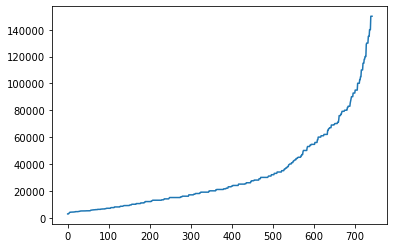

In [7]:
dns_data.prices.plot()

<AxesSubplot:>

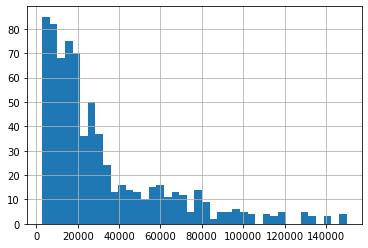

In [8]:
dns_data.prices.hist(bins=40)

<AxesSubplot:>

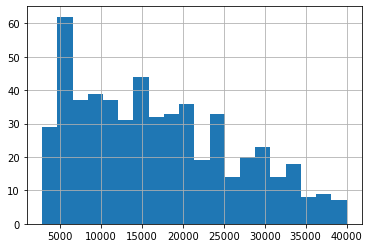

In [9]:
dns_data.prices[dns_data.prices <= 40000].hist(bins=20)

In [11]:
dns_data.to_csv("Downloads\\dns_data_smartphones(13.06.22).csv")


## Regular expressions

Использую регулярные выражения, чтобы получить признаки телефона из его названия на сайте.

In [640]:
import re

In [653]:
diag = []
for i in dns_data.smartphones:
    diag.append(float(re.search("\d.\d|\d", i)[0]))
diag
dns_data["diag"] = diag
dns_data.head(3)

,smartphones,prices,links,diag
0,"4"" Смартфон DEXP A440 8 ГБ розовый [4x(1.3 ГГц...",2799,https://www.dns-shop.ru/product/d5635852337e33...,4.0
1,"4"" Смартфон DEXP A440 8 ГБ серый [4x(1.3 ГГц),...",2799,https://www.dns-shop.ru/product/7c0c6b08337d33...,4.0
2,"4"" Смартфон DEXP A440 8 ГБ синий [4x(1.3 ГГц),...",2799,https://www.dns-shop.ru/product/3a8e4fd9337f33...,4.0


In [675]:
company = []
for i in dns_data.smartphones:
#     print(i)
    company.append(re.search(r"н \b\w+\b", i)[0][2:])
dns_data["company"] = company
dns_data.head(3)

,smartphones,prices,links,diag,company
0,"4"" Смартфон DEXP A440 8 ГБ розовый [4x(1.3 ГГц...",2799,https://www.dns-shop.ru/product/d5635852337e33...,4.0,DEXP
1,"4"" Смартфон DEXP A440 8 ГБ серый [4x(1.3 ГГц),...",2799,https://www.dns-shop.ru/product/7c0c6b08337d33...,4.0,DEXP
2,"4"" Смартфон DEXP A440 8 ГБ синий [4x(1.3 ГГц),...",2799,https://www.dns-shop.ru/product/3a8e4fd9337f33...,4.0,DEXP


In [818]:
memory = []
for i in dns_data.smartphones:
#     print(i)
    memory.append(float(re.search(r"\d{1,3} ГБ", i)[0].split()[0]))
dns_data["memory"] = memory
dns_data.tail(3)

,smartphones,prices,links,diag,company,memory,resol,oper,bat
719,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2a92c6d0...,6.8,Samsung,512.0,3088х1440,12,5000.0
720,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2c92c6d0...,6.8,Samsung,512.0,3088х1440,12,5000.0
721,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2e92c6d0...,6.8,Samsung,512.0,3088х1440,12,5000.0


In [728]:
oper = []
for i in dns_data.smartphones:
#     print(i)
    oper.append(re.search(r"\d+x\d+|\d+х\d+|\d+×\d+", i)[0])
dns_data["resol"] = resol
dns_data.tail(3)

,smartphones,prices,links,diag,company,memory,resol
719,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2a92c6d0...,6.8,Samsung,512,3088х1440
720,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2c92c6d0...,6.8,Samsung,512,3088х1440
721,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2e92c6d0...,6.8,Samsung,512,3088х1440


In [819]:
oper = [] # оперативная память
for i in dns_data.smartphones:
#     print(i)
    c = None
    c = re.search(r"\d{1,3} Гб,", i)
#     print(c)
    if c is None:
#         print(c)
        oper.append(pd.NA)
    else:
        oper.append(float(c[0].split()[0]))
dns_data["oper"] = oper
dns_data.tail(3)

,smartphones,prices,links,diag,company,memory,resol,oper,bat
719,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2a92c6d0...,6.8,Samsung,512.0,3088х1440,12.0,5000.0
720,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2c92c6d0...,6.8,Samsung,512.0,3088х1440,12.0,5000.0
721,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2e92c6d0...,6.8,Samsung,512.0,3088х1440,12.0,5000.0


In [820]:
bat = []
for i in dns_data.smartphones:
#     print(i)
    с = None
    c = re.search(r"\d+ мА\*ч", i)
    if c is None:
#         bat.append(bat[-1]) # костыль, но таких случаев мало
        bat.append(pd.NA)
    else:
        bat.append(float(c[0][:-5]))
dns_data["bat"] = bat
dns_data.tail(3)

,smartphones,prices,links,diag,company,memory,resol,oper,bat
719,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2a92c6d0...,6.8,Samsung,512.0,3088х1440,12.0,5000.0
720,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2c92c6d0...,6.8,Samsung,512.0,3088х1440,12.0,5000.0
721,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2e92c6d0...,6.8,Samsung,512.0,3088х1440,12.0,5000.0


In [809]:
# dns_data.to_csv("Downloads\\dns_data_smartphones_v2.csv")

In [812]:
dns_data = dns_data.dropna()
# dns_data.to_csv("Downloads\\dns_data_smartphones_v3(11.06.22).csv")

## Some machine learning and visualisation

In [821]:
dns_data.head(3)

X = dns_data.drop(["prices", "smartphones", "links", "resol"], axis=1)
y = dns_data.prices
# X.index=range(687) 
X

,diag,company,memory,oper,bat
0,4.0,DEXP,8.0,1.0,1440.0
1,4.0,DEXP,8.0,1.0,1440.0
2,4.0,DEXP,8.0,1.0,1440.0
3,5.0,DEXP,8.0,1.0,2000.0
4,5.0,INOI,8.0,1.0,2500.0
...,...,...,...,...,...
717,6.8,Samsung,256.0,12.0,5000.0
718,6.8,Samsung,512.0,12.0,5000.0
719,6.8,Samsung,512.0,12.0,5000.0
720,6.8,Samsung,512.0,12.0,5000.0


In [826]:
# для работы с категориальными признаками
X = pd.get_dummies(X)
X.head()

,diag,memory,oper,bat,company_ASUS,company_AYYA,company_Apple,company_BQ,company_Black,company_Blackview,...,company_OSCAL,company_Oukitel,company_POCO,company_Poco,company_Samsung,company_TCL,company_Tecno,company_Vivo,company_Xiaomi,company_realme
0,4.0,8.0,1.0,1440.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.0,8.0,1.0,1440.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.0,8.0,1.0,1440.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.0,8.0,1.0,2000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.0,8.0,1.0,2500.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Linear regression

In [881]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

rs = 4

X_train, X_test, y_train, y_test = train_test_split(X.loc[:, ["diag","memory","oper","bat"]], y,
                                                    test_size=0.4,
                                                   random_state=rs)
X_train.head(5)

,diag,memory,oper,bat
639,6.1,256.0,4.0,2815.0
615,5.4,256.0,4.0,2227.0
657,6.1,256.0,8.0,3700.0
303,6.7,128.0,4.0,5000.0
677,6.8,128.0,8.0,5000.0


In [882]:
regr = LinearRegression()
regr.fit(X_train, y_train)
regr.coef_

array([-791.37771357,  132.46716947, 4573.20204044,   -4.79834783])

In [883]:
y_pred = regr.predict(X_test)

In [884]:
from sklearn.metrics import r2_score
r2_score(y_true=y_test, y_pred=y_pred)

0.6285728773631254

Из значения R2 score вытекает вывод, что с помощью знаний о диагонали, памяти, оперативной памяти и баттарей нельзя сделать однозначный вывод о цене телефона с помощью простой линейной регрессии. Попробуем добавить двоичный логарифм памяти телефона в качестве признака, улучшится ли оценка?

In [885]:
X["log_memory"] = np.log2(X.memory)
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, ["diag","log_memory","oper","bat"]], y,
                                                    test_size=0.4,
                                                   random_state=rs)
regr = LinearRegression()
regr.fit(X_train, y_train)
regr.coef_

array([-3.94421922e+03,  7.57420823e+03,  5.37694120e+03, -5.96498681e+00])

In [886]:
y_pred = regr.predict(X_test)
r2_score(y_true=y_test, y_pred=y_pred)

0.6003091177816302

Результат заметно не изменился. Также выведу регрессии по одному аргументу.

<AxesSubplot:xlabel='diag', ylabel='prices'>

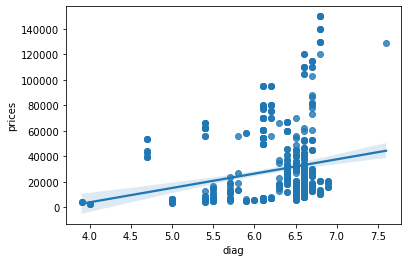

In [890]:
sns.regplot(x=X.diag, y=y, s)

<AxesSubplot:xlabel='bat', ylabel='prices'>

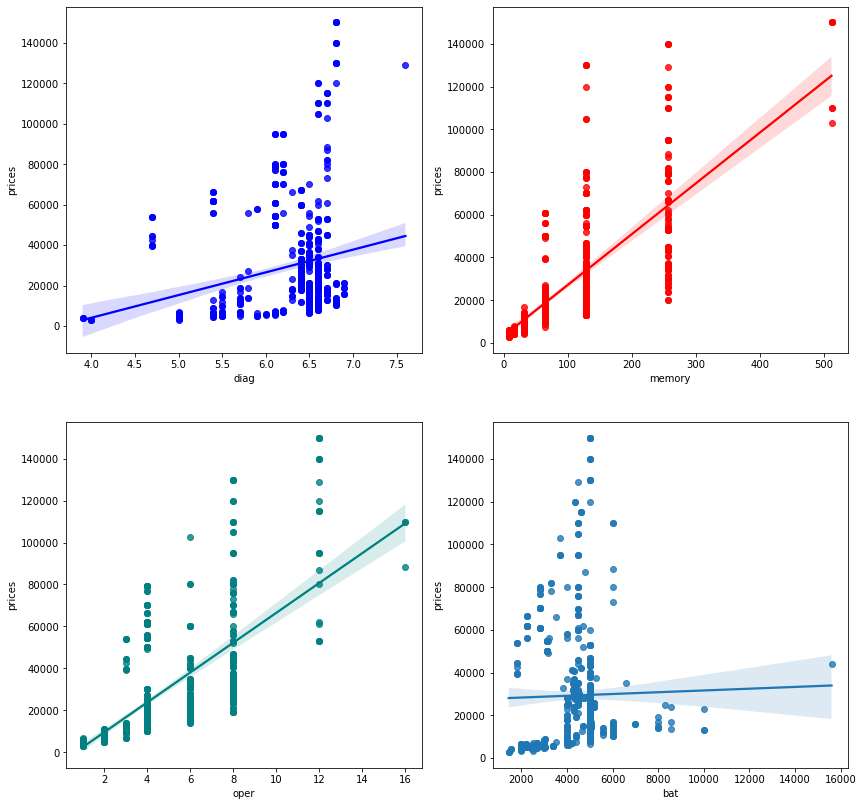

In [908]:
# Линейная регрессия по каждому признаку
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
sns.regplot(x=X.diag, y=y,ax=ax[0, 0], color="b")
sns.regplot(x=X.memory, y=y,ax=ax[0, 1], color="r")
sns.regplot(x=X.oper, y=y,ax=ax[1, 0], color="teal")
sns.regplot(x=X.bat, y=y,ax=ax[1, 1])

Из графиков следует, что большинство телефонов имеют батарею от 4000 до 6000 тысяч вне зависимости от цены. Аналогично, диагональ телефонов в основном колеблется около 6.5, при этом маленькие телефоны скорее всего не дорогие. Оба вида памяти являются довольно важным признаком и имеют похожее распределение.


Теперь построим по всем признакам. До этого я уже обработал данные, чтобы мы могли использовать категориальные признаки.

In [969]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=["log_memory"]), y,
                                                    test_size=0.4,
                                                   random_state=rs+2)
regr = LinearRegression()
regr.fit(X_train, y_train)
regr.coef_

array([ 2.10770837e+03,  8.01721581e+01,  6.26608271e+03, -1.09668741e+00,
        4.37182408e+02, -8.64819104e+03,  3.59524237e+04,  5.00740489e+03,
        8.67212564e+03, -6.94671743e+03,  8.68463395e+03,  5.10030604e+03,
       -1.32590138e+04, -1.24939641e+04,  6.05784604e+04,  9.11344299e+03,
       -8.93451355e+03,  4.87405348e+03, -6.22111455e+03, -3.15522275e+03,
       -1.23068666e+04,  8.29014080e+03, -3.15191149e+03, -1.77908753e+04,
       -1.47146872e+04,  1.26864471e+04, -1.51710223e+04, -9.66808498e+03,
       -1.41358455e+04, -4.50739673e+03, -8.29119401e+03])

In [970]:
y_pred = regr.predict(X_test)
r2_score(y_true=y_test, y_pred=y_pred)

0.7845838480399019

Далее представлена таблица с коэффициентами линейной регрессии.

In [929]:
pd.DataFrame(data=[X.columns[:-1], regr.coef_]).T

,0,1
0,diag,1725.57508
1,memory,56.700113
2,oper,6441.648239
3,bat,-0.809012
4,company_ASUS,8166.36785
5,company_AYYA,-9538.012589
6,company_Apple,36342.366412
7,company_BQ,3156.92996
8,company_Black,5418.552589
9,company_Blackview,-5566.348484


Качество модели заметно повысилось. Заметим, что мы можем сделать не строгий вывод о репутации компаний/о неявных признаках, если это компания DEXP и коэффициент при признаке [телефон принадлежит DEXP] отрицательноый, то при прочих равных, телефоны DEXP стоят дешевле остальных, если коэффициент > 0, то наоборот.

Представленность фирм в разных ценовых сегментах можно увидеть на следующем графике.

In [954]:
big_comp = dns_data.groupby(["company"])\
        .count()\
        .sort_values(by="smartphones", ascending=False)\
        .index[:5]
big_comp


Index(['Samsung', 'Xiaomi', 'Apple', 'BQ', 'realme'], dtype='object', name='company')

In [956]:
big_comp_data = dns_data[dns_data.company.isin(big_comp)]
big_comp_data

,smartphones,prices,links,diag,company,memory,resol,oper,bat
7,"3.97"" Смартфон BQ 4030G Nice Mini 16 ГБ золоти...",4099,https://www.dns-shop.ru/product/cc29ec0695ba2f...,3.9,BQ,16.0,800x480,1.0,1550.0
8,"3.97"" Смартфон BQ 4030G Nice Mini 16 ГБ синий ...",4099,https://www.dns-shop.ru/product/5eca9b4a95ba2f...,3.9,BQ,16.0,800x480,1.0,1550.0
9,"3.97"" Смартфон BQ 4030G Nice Mini 16 ГБ черный...",4099,https://www.dns-shop.ru/product/874af58a95ba2f...,3.9,BQ,16.0,800x480,1.0,1550.0
12,"5"" Смартфон BQ 5031G Fun 8 ГБ зеленый [4x(1.3 ...",4199,https://www.dns-shop.ru/product/4f2070d395bc2f...,5.0,BQ,8.0,1280x720,1.0,2000.0
13,"5"" Смартфон BQ 5031G Fun 8 ГБ красный [4x(1.3 ...",4199,https://www.dns-shop.ru/product/ee44b2e295bb2f...,5.0,BQ,8.0,1280x720,1.0,2000.0
...,...,...,...,...,...,...,...,...,...
717,"6.8"" Смартфон Samsung Galaxy S22 Ultra 256 ГБ ...",139999,https://www.dns-shop.ru/product/768eec2692c6d0...,6.8,Samsung,256.0,3088х1440,12.0,5000.0
718,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec3092c6d0...,6.8,Samsung,512.0,3088х1440,12.0,5000.0
719,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2a92c6d0...,6.8,Samsung,512.0,3088х1440,12.0,5000.0
720,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999,https://www.dns-shop.ru/product/768eec2c92c6d0...,6.8,Samsung,512.0,3088х1440,12.0,5000.0


Регрессия для по отдельным компаниям

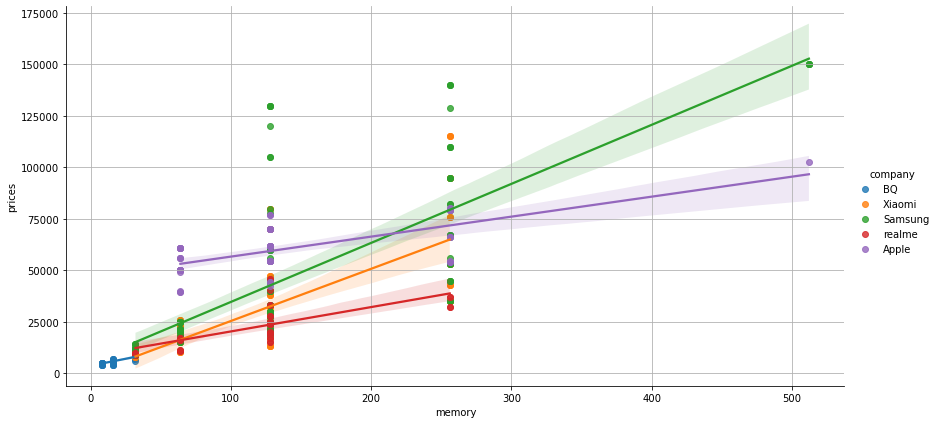

In [964]:
# fig, ax = plt.subplots(figsize=(8, 8))
sns.lmplot(x="memory", y="prices", hue="company", data=big_comp_data, height=6, aspect=2)
plt.grid()

BQ бюджетная компанияю Самсунг представлена во всех ценовых категориях. Apple располагается в сегменте цены выше среднего.

Теперь самое главное. Я парсил сайт dns 11 июня, сегодня 13 июня. Спарсим ещё раз и посмотрим изменились ли цены.

In [46]:
df13 = dns_data
df13.index = df13.links
df13 = df13.drop(columns=["links"])
df13

,smartphones,prices
links,,
https://www.dns-shop.ru/product/d5635852337e3332/4-smartfon-dexp-a440-8-gb-rozovyj/,"4"" Смартфон DEXP A440 8 ГБ розовый [4x(1.3 ГГц...",2799
https://www.dns-shop.ru/product/7c0c6b08337d3332/4-smartfon-dexp-a440-8-gb-seryj/,"4"" Смартфон DEXP A440 8 ГБ серый [4x(1.3 ГГц),...",2799
https://www.dns-shop.ru/product/3a8e4fd9337f3332/4-smartfon-dexp-a440-8-gb-sinij/,"4"" Смартфон DEXP A440 8 ГБ синий [4x(1.3 ГГц),...",2799
https://www.dns-shop.ru/product/d4aa88fc0bf43332/5-smartfon-dexp-g450-8-gb-sinij/,"5"" Смартфон DEXP G450 8 ГБ синий [4x(1.3 ГГц),...",3199
https://www.dns-shop.ru/product/24c3777825b1ed20/5-smartfon-inoi-easyphone-8-gb-cernyj/,"5"" Смартфон INOI easyPhone 8 ГБ черный [4x(1.3...",3499
...,...,...
https://www.dns-shop.ru/product/768eec2692c6d050/68-smartfon-samsung-galaxy-s22-ultra-256-gb-cernyj/,"6.8"" Смартфон Samsung Galaxy S22 Ultra 256 ГБ ...",139999
https://www.dns-shop.ru/product/768eec3092c6d050/68-smartfon-samsung-galaxy-s22-ultra-512-gb-belyj/,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999
https://www.dns-shop.ru/product/768eec2a92c6d050/68-smartfon-samsung-galaxy-s22-ultra-512-gb-bordovyj/,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999


In [47]:
df11 = pd.read_csv("Downloads\\dns_data_smartphones_v2.csv").loc[:,["smartphones","prices","links"]]
df11.index = df11.links
df11 = df11.drop(columns=["links"])
df11

,smartphones,prices
links,,
https://www.dns-shop.ru/product/d5635852337e3332/4-smartfon-dexp-a440-8-gb-rozovyj/,"4"" Смартфон DEXP A440 8 ГБ розовый [4x(1.3 ГГц...",2799
https://www.dns-shop.ru/product/7c0c6b08337d3332/4-smartfon-dexp-a440-8-gb-seryj/,"4"" Смартфон DEXP A440 8 ГБ серый [4x(1.3 ГГц),...",2799
https://www.dns-shop.ru/product/3a8e4fd9337f3332/4-smartfon-dexp-a440-8-gb-sinij/,"4"" Смартфон DEXP A440 8 ГБ синий [4x(1.3 ГГц),...",2799
https://www.dns-shop.ru/product/d4aa88fc0bf43332/5-smartfon-dexp-g450-8-gb-sinij/,"5"" Смартфон DEXP G450 8 ГБ синий [4x(1.3 ГГц),...",3199
https://www.dns-shop.ru/product/24c3777825b1ed20/5-smartfon-inoi-easyphone-8-gb-cernyj/,"5"" Смартфон INOI easyPhone 8 ГБ черный [4x(1.3...",3499
...,...,...
https://www.dns-shop.ru/product/768eec2692c6d050/68-smartfon-samsung-galaxy-s22-ultra-256-gb-cernyj/,"6.8"" Смартфон Samsung Galaxy S22 Ultra 256 ГБ ...",139999
https://www.dns-shop.ru/product/768eec3092c6d050/68-smartfon-samsung-galaxy-s22-ultra-512-gb-belyj/,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999
https://www.dns-shop.ru/product/768eec2a92c6d050/68-smartfon-samsung-galaxy-s22-ultra-512-gb-bordovyj/,"6.8"" Смартфон Samsung Galaxy S22 Ultra 512 ГБ ...",149999


In [48]:
J = df11.join(df13, how="inner",lsuffix='_old', rsuffix='_new')
J.head(2)

,smartphones_old,prices_old,smartphones_new,prices_new
links,,,,
https://www.dns-shop.ru/product/007767aa88502ff0/667-smartfon-poco-f3-256-gb-sinij/,"6.67"" Смартфон POCO F3 256 ГБ синий [8x(3.2 ГГ...",29999,"6.67"" Смартфон POCO F3 256 ГБ синий [8x(3.2 ГГ...",29999
https://www.dns-shop.ru/product/00ce6b2315cbed20/61-smartfon-apple-iphone-13-128-gb-krasnyj/,"6.1"" Смартфон Apple iPhone 13 128 ГБ красный [...",82999,"6.1"" Смартфон Apple iPhone 13 128 ГБ красный [...",82999


In [50]:
delta = J.prices_new - J.prices_old
J["delta"] = delta
J.sort_values(by="delta")

,smartphones_old,prices_old,smartphones_new,prices_new,delta
links,,,,,
https://www.dns-shop.ru/product/8178d3d58e21ed20/628-smartfon-xiaomi-12x-128-gb-seryj/,"6.28"" Смартфон Xiaomi 12X 128 ГБ серый [8x(3.2...",69999,"6.28"" Смартфон Xiaomi 12X 128 ГБ серый [8x(3.2...",64999,-5000
https://www.dns-shop.ru/product/aa40b21b8e23ed20/628-smartfon-xiaomi-12x-256-gb-goluboj/,"6.28"" Смартфон Xiaomi 12X 256 ГБ голубой [8x(3...",75999,"6.28"" Смартфон Xiaomi 12X 256 ГБ голубой [8x(3...",70999,-5000
https://www.dns-shop.ru/product/bd4b58f78e21ed20/628-smartfon-xiaomi-12x-128-gb-goluboj/,"6.28"" Смартфон Xiaomi 12X 128 ГБ голубой [8x(3...",69999,"6.28"" Смартфон Xiaomi 12X 128 ГБ голубой [8x(3...",64999,-5000
https://www.dns-shop.ru/product/7a44a9808e23ed20/628-smartfon-xiaomi-12x-256-gb-seryj/,"6.28"" Смартфон Xiaomi 12X 256 ГБ серый [8x(3.2...",75999,"6.28"" Смартфон Xiaomi 12X 256 ГБ серый [8x(3.2...",70999,-5000
https://www.dns-shop.ru/product/f00f42258e23ed20/628-smartfon-xiaomi-12x-256-gb-fioletovyj/,"6.28"" Смартфон Xiaomi 12X 256 ГБ фиолетовый [8...",75999,"6.28"" Смартфон Xiaomi 12X 256 ГБ фиолетовый [8...",70999,-5000
...,...,...,...,...,...
https://www.dns-shop.ru/product/60e098b0a3072ff1/643-smartfon-oppo-a74-128-gb-sinij/,"6.43"" Смартфон OPPO A74 128 ГБ синий [8x(2 ГГц...",18999,"6.43"" Смартфон OPPO A74 128 ГБ синий [8x(2 ГГц...",18999,0
https://www.dns-shop.ru/product/614c5ff3ff02d763/65-smartfon-xiaomi-redmi-10-128-gb-belyj/,"6.5"" Смартфон Xiaomi Redmi 10 128 ГБ белый [8x...",16999,"6.5"" Смартфон Xiaomi Redmi 10 128 ГБ белый [8x...",16999,0
https://www.dns-shop.ru/product/61d4a243f00ad763/65-smartfon-samsung-galaxy-a12-64-gb-cernyj-a127f/,"6.5"" Смартфон Samsung Galaxy A12 64 ГБ черный ...",15999,"6.5"" Смартфон Samsung Galaxy A12 64 ГБ черный ...",15999,0


In [51]:
J[J.delta < 0]

,smartphones_old,prices_old,smartphones_new,prices_new,delta
links,,,,,
https://www.dns-shop.ru/product/0fd009d2280bed20/655-smartfon-xiaomi-11-lite-5g-ne-256-gb-goluboj/,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 256 ГБ гол...",34999,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 256 ГБ гол...",33999,-1000
https://www.dns-shop.ru/product/225b744c3ba8ed20/655-smartfon-xiaomi-11-lite-5g-ne-256-gb-zelenyj/,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 256 ГБ зел...",34999,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 256 ГБ зел...",33999,-1000
https://www.dns-shop.ru/product/2779335111f6ed20/655-smartfon-xiaomi-11-lite-5g-ne-128-gb-goluboj/,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 128 ГБ гол...",31999,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 128 ГБ гол...",30999,-1000
https://www.dns-shop.ru/product/33b9b017280bed20/655-smartfon-xiaomi-11-lite-5g-ne-256-gb-rozovyj/,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 256 ГБ роз...",34999,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 256 ГБ роз...",33999,-1000
https://www.dns-shop.ru/product/4a85421911f6ed20/655-smartfon-xiaomi-11-lite-5g-ne-128-gb-rozovyj/,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 128 ГБ роз...",31999,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 128 ГБ роз...",30999,-1000
https://www.dns-shop.ru/product/4c34458e280bed20/655-smartfon-xiaomi-11-lite-5g-ne-256-gb-belyj/,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 256 ГБ бел...",34999,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 256 ГБ бел...",33999,-1000
https://www.dns-shop.ru/product/51d4320b71d8ed20/643-smartfon-xiaomi-redmi-note-11-128-gb-sinij/,"6.43"" Смартфон Xiaomi Redmi Note 11 128 ГБ син...",23999,"6.43"" Смартфон Xiaomi Redmi Note 11 128 ГБ син...",22999,-1000
https://www.dns-shop.ru/product/5f92436a71d7ed20/643-smartfon-xiaomi-redmi-note-11-64-gb-sinij/,"6.43"" Смартфон Xiaomi Redmi Note 11 64 ГБ сини...",22999,"6.43"" Смартфон Xiaomi Redmi Note 11 64 ГБ сини...",20999,-2000
https://www.dns-shop.ru/product/670453f1280bed20/655-smartfon-xiaomi-11-lite-5g-ne-256-gb-cernyj/,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 256 ГБ чер...",34999,"6.55"" Смартфон Xiaomi 11 Lite 5G NE 256 ГБ чер...",33999,-1000


Как мы видим, за 2 дня цена на некоторые смартфоны стала меньше. И ни один не подорожал. Возможно для новых более дорогих смартфонов dns создаёт новые ссылки, тогда вывод может быть не верным.

## Рабочий код API СДЭК + немного графов

In [67]:
weights = []
cities_from = []
cities_to = []
dates = []

In [68]:
## import requests

### использовал сервис CURL -> requests и немного редактировал

headers = {
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="102", "Google Chrome";v="102"',
    'sec-ch-ua-mobile': '?0',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.63 Safari/537.36',
    'x-raw-body': '{"operationName":"getTrackingInfo"}',
    # Already added when you pass json=
    # 'content-type': 'application/json',
    'accept': '*/*',
    'Referer': 'https://www.cdek.ru/ru/tracking?order_id=1261935378',
    'sec-ch-ua-platform': '"Windows"',
}

json_data = {
    'operationName': 'getTrackingInfo',
    'variables': {
        'trackId': '1261935378',
        'websiteId': 'ru',
        'locale': 'ru',
        'token': None,
    },
    'query': 'query getTrackingInfo($trackId: String!, $phone: String, $websiteId: String!, $locale: String!, $token: String) {\n  tracking: trackingInfo(trackId: $trackId, phone: $phone, websiteId: $websiteId, locale: $locale, token: $token) {\n    success\n    orderNumber\n    status {\n      code\n      name\n      note\n      date\n      __typename\n    }\n    statuses {\n      code\n      name\n      note\n      date\n      completed\n      items {\n        code\n        name\n        statuses {\n          code\n          name\n          date\n          __typename\n        }\n        __typename\n      }\n      __typename\n    }\n    cityFrom {\n      code\n      name\n      __typename\n    }\n    cityTo {\n      code\n      name\n      __typename\n    }\n    orderDate\n    tariffDateEnd\n    storageDateEnd\n    deliveryAgreementDate\n    returnOrderNumber\n    weight\n    stockType\n    receiver {\n      initials\n      address {\n        title\n        city {\n          code\n          name\n          __typename\n        }\n        office {\n          systemName\n          type\n          worktime\n          notes\n          pathForWebView\n          __typename\n        }\n        __typename\n      }\n      __typename\n    }\n    notes {\n      code\n      name\n      __typename\n    }\n    nonDeliveryNote {\n      code\n      name\n      __typename\n    }\n    errors {\n      message\n      code\n      __typename\n    }\n    specialNote\n    __typename\n  }\n}\n',
}
### конец использования сервиса

n = 1000
order = 1304571000 + 2042


for i in range(n):
    json_data["variables"]["trackId"] = str(order + i)
    response = requests.post('https://www.cdek.ru/graphql', headers=headers, json=json_data)
    if not response.ok:
        continue
    response = response.json()
    if response["data"]["tracking"]["success"] == False:
        continue
    weights.append(response["data"]["tracking"]["weight"])
    cities_from.append(response["data"]["tracking"]["cityFrom"]["name"])
    cities_to.append(response["data"]["tracking"]["cityTo"]["name"])
    dates.append(response["data"]["tracking"]["orderDate"])
    sleep(0.5)
    if i % 10 == 0:
        print(i)
        sleep(5)
dates

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


['2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-02',
 '2022-01-

In [73]:
df = pd.DataFrame([cities_from, cities_to, weights]).T
# df
df.to_csv("Downloads\\next900orders.csv")
df

,0,1,2
0,Салехард,Салехард,1
1,Калининград,Калининград,1
2,Ростов-на-Дону,Ростов-на-Дону,1
3,Ростов-на-Дону,Зерноград,1
4,Ростов-на-Дону,Белая Калитва,1
...,...,...,...
905,Москва,Москва,0.075
906,Москва,Калининград,0.043
907,Москва,Улан-Удэ,0.029
908,Москва,Санкт-Петербург,0.033


In [76]:
# Здесь я исправлял небольшой баг, больше запускать ячейку не нужно
# cities_to = df.iloc[:, 0][df.index % 2 == 1]
# cities_from = df.iloc[:, 0][df.index % 2 == 0]
cities_to

['Салехард',
 'Калининград',
 'Ростов-на-Дону',
 'Зерноград',
 'Белая Калитва',
 'Калининград',
 'Омск',
 'Ижевск',
 'Омск',
 'Ростов-на-Дону',
 'Омск',
 'Улан-Удэ',
 'Владивосток',
 'Омск',
 'Темрюк',
 'Саратов',
 'Новошахтинск',
 'Ростов-на-Дону',
 'Тюмень',
 'Ростов-на-Дону',
 'Сочи',
 'Ростов-на-Дону',
 'Казань',
 'Магадан',
 'Ростов-на-Дону',
 'Верхнебаканский',
 'Ростов-на-Дону',
 'Ростов-на-Дону',
 'Калачинск',
 'Новосибирск',
 'Незлобная',
 'Темрюк',
 'Самара',
 'Сочи',
 'Весёлое, Сочи гор.округ',
 'Юбилейный мкр. (Королёв)',
 'Москва',
 'Москва',
 'Челябинск',
 'Анапа',
 'Лобня',
 'Белоозерский',
 'Волгодонск',
 'Курск',
 'Москва',
 'Актау',
 'Ульяновск',
 'Рыбное',
 'Москва',
 'Дзержинский',
 'Екатеринбург',
 'Электроугли',
 'Великий Новгород',
 'Смольки, Городецкий р-н',
 'Астрахань',
 'Новосибирск',
 'Менделеево, Солнечногорский р-он',
 'Казань',
 'Ижевск',
 'Астрахань',
 'Уфа',
 'Нефтеюганск',
 'Вологда',
 'Муром',
 'Липецк',
 'Стерлитамак',
 'Митино',
 'Сочи',
 'Пущино',


In [77]:
dt = pd.DataFrame(columns=["city_from", "city_to", "weight"])
dt.city_from = list(cities_from)
# dt.index = range(1611)
dt.city_to = list(cities_to)
dt.weight = weights
dt

,city_from,city_to,weight
0,Салехард,Салехард,1.000
1,Калининград,Калининград,1.000
2,Ростов-на-Дону,Ростов-на-Дону,1.000
3,Ростов-на-Дону,Зерноград,1.000
4,Ростов-на-Дону,Белая Калитва,1.000
...,...,...,...
905,Москва,Москва,0.075
906,Москва,Калининград,0.043
907,Москва,Улан-Удэ,0.029
908,Москва,Санкт-Петербург,0.033


Через некоторое количество реквестов, даже с паузами цикл реквестов ломался, поэтому сейчас я объединю все данные, которые я смог получить.

In [ ]:
df1 = pd.read_csv("Downloads\\first1611orders.csv").drop(columns=["Unnamed: 0"])
df1.head(3)

In [88]:
df2 = pd.read_csv("Downloads\\next100orders.csv").drop(columns=["Unnamed: 0"])
df2.columns=["city_from","city_to","weight"]
df2.head(3)

,city_from,city_to,weight
0,Нижний Новгород,Нижний Новгород,1.0
1,Ульяновск,Ульяновск,1.0
2,Нижний Новгород,Нижний Новгород,1.0


In [90]:
df3 = pd.read_csv("Downloads\\next900orders.csv").drop(columns=["Unnamed: 0"])
df3.columns=["city_from","city_to","weight"]
df3.head(3)

,city_from,city_to,weight
0,Салехард,Салехард,1.0
1,Калининград,Калининград,1.0
2,Ростов-на-Дону,Ростов-на-Дону,1.0


Объеденим все датафреймы

In [130]:
postdf = pd.concat([df1, df2, df3], ignore_index=True)
postdf.to_csv("Downloads\\postdf.csv")
postdf

,city_from,city_to,weight
0,Ростов-на-Дону,Бор,0.300
1,Москва,Волгоград,5.000
2,Сочи,Москва,0.060
3,Добрянка,Пермь,0.100
4,Зерноград,Санкт-Петербург,0.500
...,...,...,...
2616,Москва,Москва,0.075
2617,Москва,Калининград,0.043
2618,Москва,Улан-Удэ,0.029
2619,Москва,Санкт-Петербург,0.033


Далее я обрабатываю данные, суммирую все перевозки в обе стороны и убираю дубликаты. То есть теперь будет Ижевск Москва с весом = k, но не будет Москва - Ижевск. Заметим, что это зависит от лексикографического порядка.

In [97]:
D = {}
for i in postdf.index:
    fr, to, w = postdf.iloc[i, :]
    wedge = tuple(sorted((fr, to)))
    if wedge[0] not in D:
        D[wedge[0]] = {}
        D[wedge[0]][wedge[1]] = w
    else:
        if wedge[1] not in D[wedge[0]]:
            D[wedge[0]][wedge[1]] = w
        else:
            D[wedge[0]][wedge[1]] += w
D

{'Бор': {'Ростов-на-Дону': 0.3},
 'Волгоград': {'Москва': 8.111,
  'Ростов-на-Дону': 3.0,
  'Саратов': 5.5,
  'Набережные Челны': 1.0,
  'Нижний Новгород': 23.46,
  'Ижевск': 0.7,
  'Тула': 0.5,
  'Дзержинский': 2.0,
  'Ульяновск': 0.5,
  'Чита': 2.0,
  'Волгоград': 5.0,
  'Урюпинск': 3.0,
  'Михайловка': 1.0,
  'Камышин': 2.0,
  'Котово': 1.0,
  'Краснодар': 2.0,
  'Санкт-Петербург': 0.4,
  'Химки Новые': 1.0},
 'Москва': {'Сочи': 9.724,
  'Рязань': 13.02,
  'Новокузнецк': 2.533,
  'Ярославль': 7.243,
  'Санкт-Петербург': 89.62500000000009,
  'Ступино': 1.4,
  'Москва': 68.38900000000002,
  'Ставрополь': 4.94,
  'Рыбинск': 6.22,
  'Пятигорск': 1.2000000000000002,
  'Павловский Посад': 5.45,
  'Саратов': 2.7479999999999998,
  'Селятино': 1.2,
  'Некрасовка район': 1.5,
  'Тамбов': 2.379,
  'Петрозаводск': 0.2,
  'Чебоксары': 0.7,
  'Северодвинск': 1.9,
  'Сиверский, Гатчинский р-н': 0.3,
  'Серпухов': 2.0,
  'Усолье-Сибирское': 0.441,
  'Подольск': 0.29400000000000004,
  'Реутов': 0.93

Теперь можно создать граф.

In [104]:
G = nx.Graph()

for i in D.keys():
    for j in D[i].keys():
#         print(i, j, D[i][j])
        G.add_edge(i, j, weight= D[i][j])

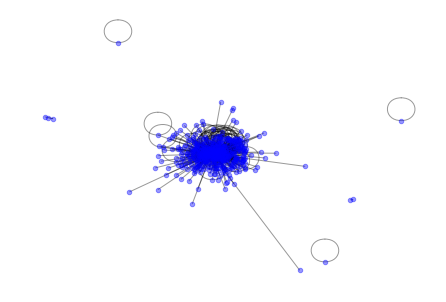

In [126]:
nx.draw(G, alpha=0.4, node_size=20, node_color="blue")

In [110]:
# Неудивительно, 6 компонент связности
nx.number_connected_components(G)

6

In [118]:
# Выведем число вершин(насёлённых пунктов за 2600 посылок)
G.number_of_nodes()

486

In [119]:
# Выведем число рёбер в графе
G.number_of_edges()

925

Граф довольно разряженный, но в основном связный. При том, что мы использовали лишь очень малую часть данных. Данные это выборка из 2600 подряд идущих заказов.

Теперь откройте файл "map with cargo routes" там находится финальная часть проекта, я визуализирую объём поставок на реальной карте. (Сори за неудобства). И подвожу итоги.